In [1]:
import sys
sys.path.append("..")

In [2]:
import os

# prevent JAX from preallocating all GPU memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# data loading
import pandas as pd
import numpy as np

# plotting
import arviz as az
import matplotlib.pyplot as plt

# pyro
import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive
from numpyro.handlers import condition, trace
from numpyro.contrib.control_flow import scan, cond

numpyro.set_host_device_count(4)

# jax
import jax
import jax.numpy as jnp
import jax.random as random

if any([d.platform == "gpu" for d in jax.devices()]):
    numpyro.set_platform("gpu")

from jax.lib import xla_bridge
print(f"current XLA device: {xla_bridge.get_backend().platform}")

import weathergen as wx
import wxsbi

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


current XLA device: cpu


In [3]:
# enable autoreload of source files
%load_ext autoreload
%autoreload 2

Here we auto-download the E-OBS basin data, if necessary.

In [4]:
import os.path, requests, zipfile

def maybe_download(url, filepath):
    # download file if not available
    if not os.path.isfile(filepath):
        r = requests.get(url, stream=True)
        with open(filepath, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

eobs_basin_data_archive = os.path.join("..", "data", "eobs-basins", "eobs_basin_data.zip")
maybe_download("https://nextcloud.awi.de/s/kRkPr3pwXYLMJ7g/download/eobs_basin_data.zip", eobs_basin_data_archive)
with zipfile.ZipFile(eobs_basin_data_archive, "r") as zf:
    zf.extractall("../data/eobs-basins")

In [5]:
basin_id = 6340800
basin_info = pd.read_csv("../data/eobs-basins/basins_info.csv")
name_map = wx.data.data_var_name_map(prec="pre", Tair_mean="tavg", Tair_min="tmin", Tair_max="tmax")
basin_data_all = wx.data.load_time_series_csv("../data/eobs-basins/eobs_basins_averaged_all.csv", name_map)


In [6]:
basin_data = basin_data_all.loc[basin_data_all.id == basin_id].drop(columns=basin_data_all.columns[0])

In [7]:
basin_info[basin_info.id == basin_id]

,id,wmo_reg,sub_reg,river,station,country,lat,lon,area,altitude_station,...,r_volume_yr,r_height_yr,clay,sand,mineral_bulk_density,altitude_basin,forest,impervious,pervious,slope
531,6340800,6,6401,SPREE,SPREMBERG,DE,51.577,14.37,2092.0,91.52,...,0.505018,241.404161,0.142248,0.526502,0.012846,206.270072,0.386012,0.024523,0.589464,2.507489


In [8]:
# prec_summary_ref = basin_data_ref.pre.groupby(basin_data_ref.index.year).apply(
#     lambda x: pd.DataFrame(wx.utils.precip_summary_stats(jnp.array(x)).reshape((1,-1)), columns=["ptot", "p99", "pmean", "wd", "cdd"])
# ).reset_index().drop('level_1', axis=1).set_index('time')
# tair_summary_ref = basin_data_ref.tavg.groupby(basin_data_ref.index.year).apply(
#     lambda x: pd.DataFrame(wx.utils.tair_summary_stats(jnp.array(x)).reshape((1,-1)), columns=['T10','T50','T90','TDD','FDD'])
# ).reset_index().drop('level_1', axis=1).set_index('time')

In [9]:
basin_data_train = basin_data["1950":"1990"]
# Tair_freqs = np.array([1.0,2.0,5.0,10.0,20.0])/(365.25*10)
# prec_freqs = np.array([1.0,2.0,5.0,10.0,20.0])/(365.25*10)
Tair_freqs = wx.utils.truncated_fft(basin_data_train.Tair_mean.values, nfreqs=5)["freq"]
prec_freqs = wx.utils.truncated_fft(basin_data_train.prec.values, nfreqs=5)["freq"]
1/Tair_freqs

0     365.243902
1    2995.000000
2     194.480519
3     125.840336
4      21.546763
Name: freq, dtype: float64

In [10]:
wgen_args = (wx.wgen_glm_v3,)
wgen_kwargs = dict(order=2, Tair_freqs=Tair_freqs, prec_freqs=prec_freqs)
wgen = wx.WGEN(basin_data_train, *wgen_args, **wgen_kwargs)

In [11]:
from numpyro.infer import SVI, TraceGraph_ELBO
from numpyro.infer.autoguide import AutoDelta, AutoNormal, AutoMultivariateNormal

num_iter = 30_000
prng = random.PRNGKey(1234)
guide = AutoMultivariateNormal(wgen.step, init_loc_fn=numpyro.infer.init_to_median)
svi_result = wgen.fit("svi", num_iter, guide, subsample_time=1000, rng=prng)

100%|██████████| 30000/30000 [01:53<00:00, 264.56it/s, init loss: 1885558.0000, avg. loss [28501-30000]: 84819.5703]


In [19]:
posterior_sampler = Predictive(guide, params=svi_result.params, num_samples=100)
posterior_params = posterior_sampler(prng)
{k: v.mean(axis=0) for k,v in posterior_params.items() if k != "_auto_latent"}

{'Tavg_lag': Array([-0.19298561,  0.95129794], dtype=float32),
 'Tavg_pred': Array([2.202465], dtype=float32),
 'Tavg_seasonal': Array([-0.70484585,  0.03952773,  0.14314769,  0.07658952,  0.11772633,
        -2.5079744 ,  0.17510095,  0.0563805 , -0.14175117, -0.13032   ],      dtype=float32),
 'Tavg_seasonal&lag1': Array([ 0.01015578, -0.00243707, -0.00582927, -0.00801689, -0.00473808,
         0.03000607, -0.00599379, -0.00013399,  0.00577605,  0.00741878],      dtype=float32),
 'Trange_mean_Tavg': Array([0.3113271], dtype=float32),
 'Trange_mean_pred': Array([5.475856], dtype=float32),
 'Trange_mean_seasonal': Array([ 0.8602633 , -0.0568995 , -0.02708339,  0.03435925,  0.001823  ,
        -0.7020661 ,  0.04315276,  0.03689034, -0.01266156,  0.01810618],      dtype=float32),
 'Trange_mean_wet': Array([-1.7859241], dtype=float32),
 'Trange_shape_Tavg': Array([0.48171324], dtype=float32),
 'Trange_shape_pred': Array([3.250935], dtype=float32),
 'Trange_shape_seasonal': Array([ 1.28523

In [20]:
svi_predictive = Predictive(wgen.simulate, posterior_samples=posterior_params, parallel=True)
svi_preds = svi_predictive(prng)

In [21]:
obs = wgen.obs

In [22]:
np.corrcoef((svi_preds['prec'] <= 0).squeeze().T[:-1,0], (svi_preds['prec'] <= 0).squeeze().T[1:,0])

array([[1.        , 0.34488757],
       [0.34488757, 1.        ]])

In [23]:
np.corrcoef((obs['prec'] <= 0).squeeze()[:-1], (obs['prec'] <= 0).squeeze()[1:])

array([[1.       , 0.3420201],
       [0.3420201, 1.       ]])

In [24]:
svi_preds["Tavg"].shape

(100, 14975, 1)

In [25]:
(obs["prec"] > 0).mean()

Array(0.46417361, dtype=float32)

In [26]:
(svi_preds["prec"][0,:] > 0).mean()

Array(0.45609346, dtype=float32)

(0.0, 20.0)

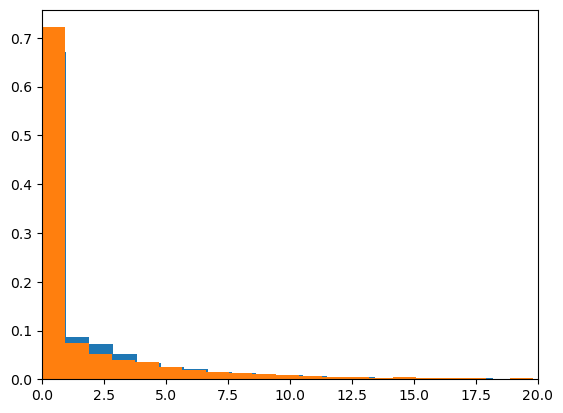

In [27]:
plt.hist(obs['prec'].squeeze(), bins=100, density=True)
plt.hist(svi_preds['prec'][0,:].squeeze(), bins=100, density=True)
plt.xlim((0,20))

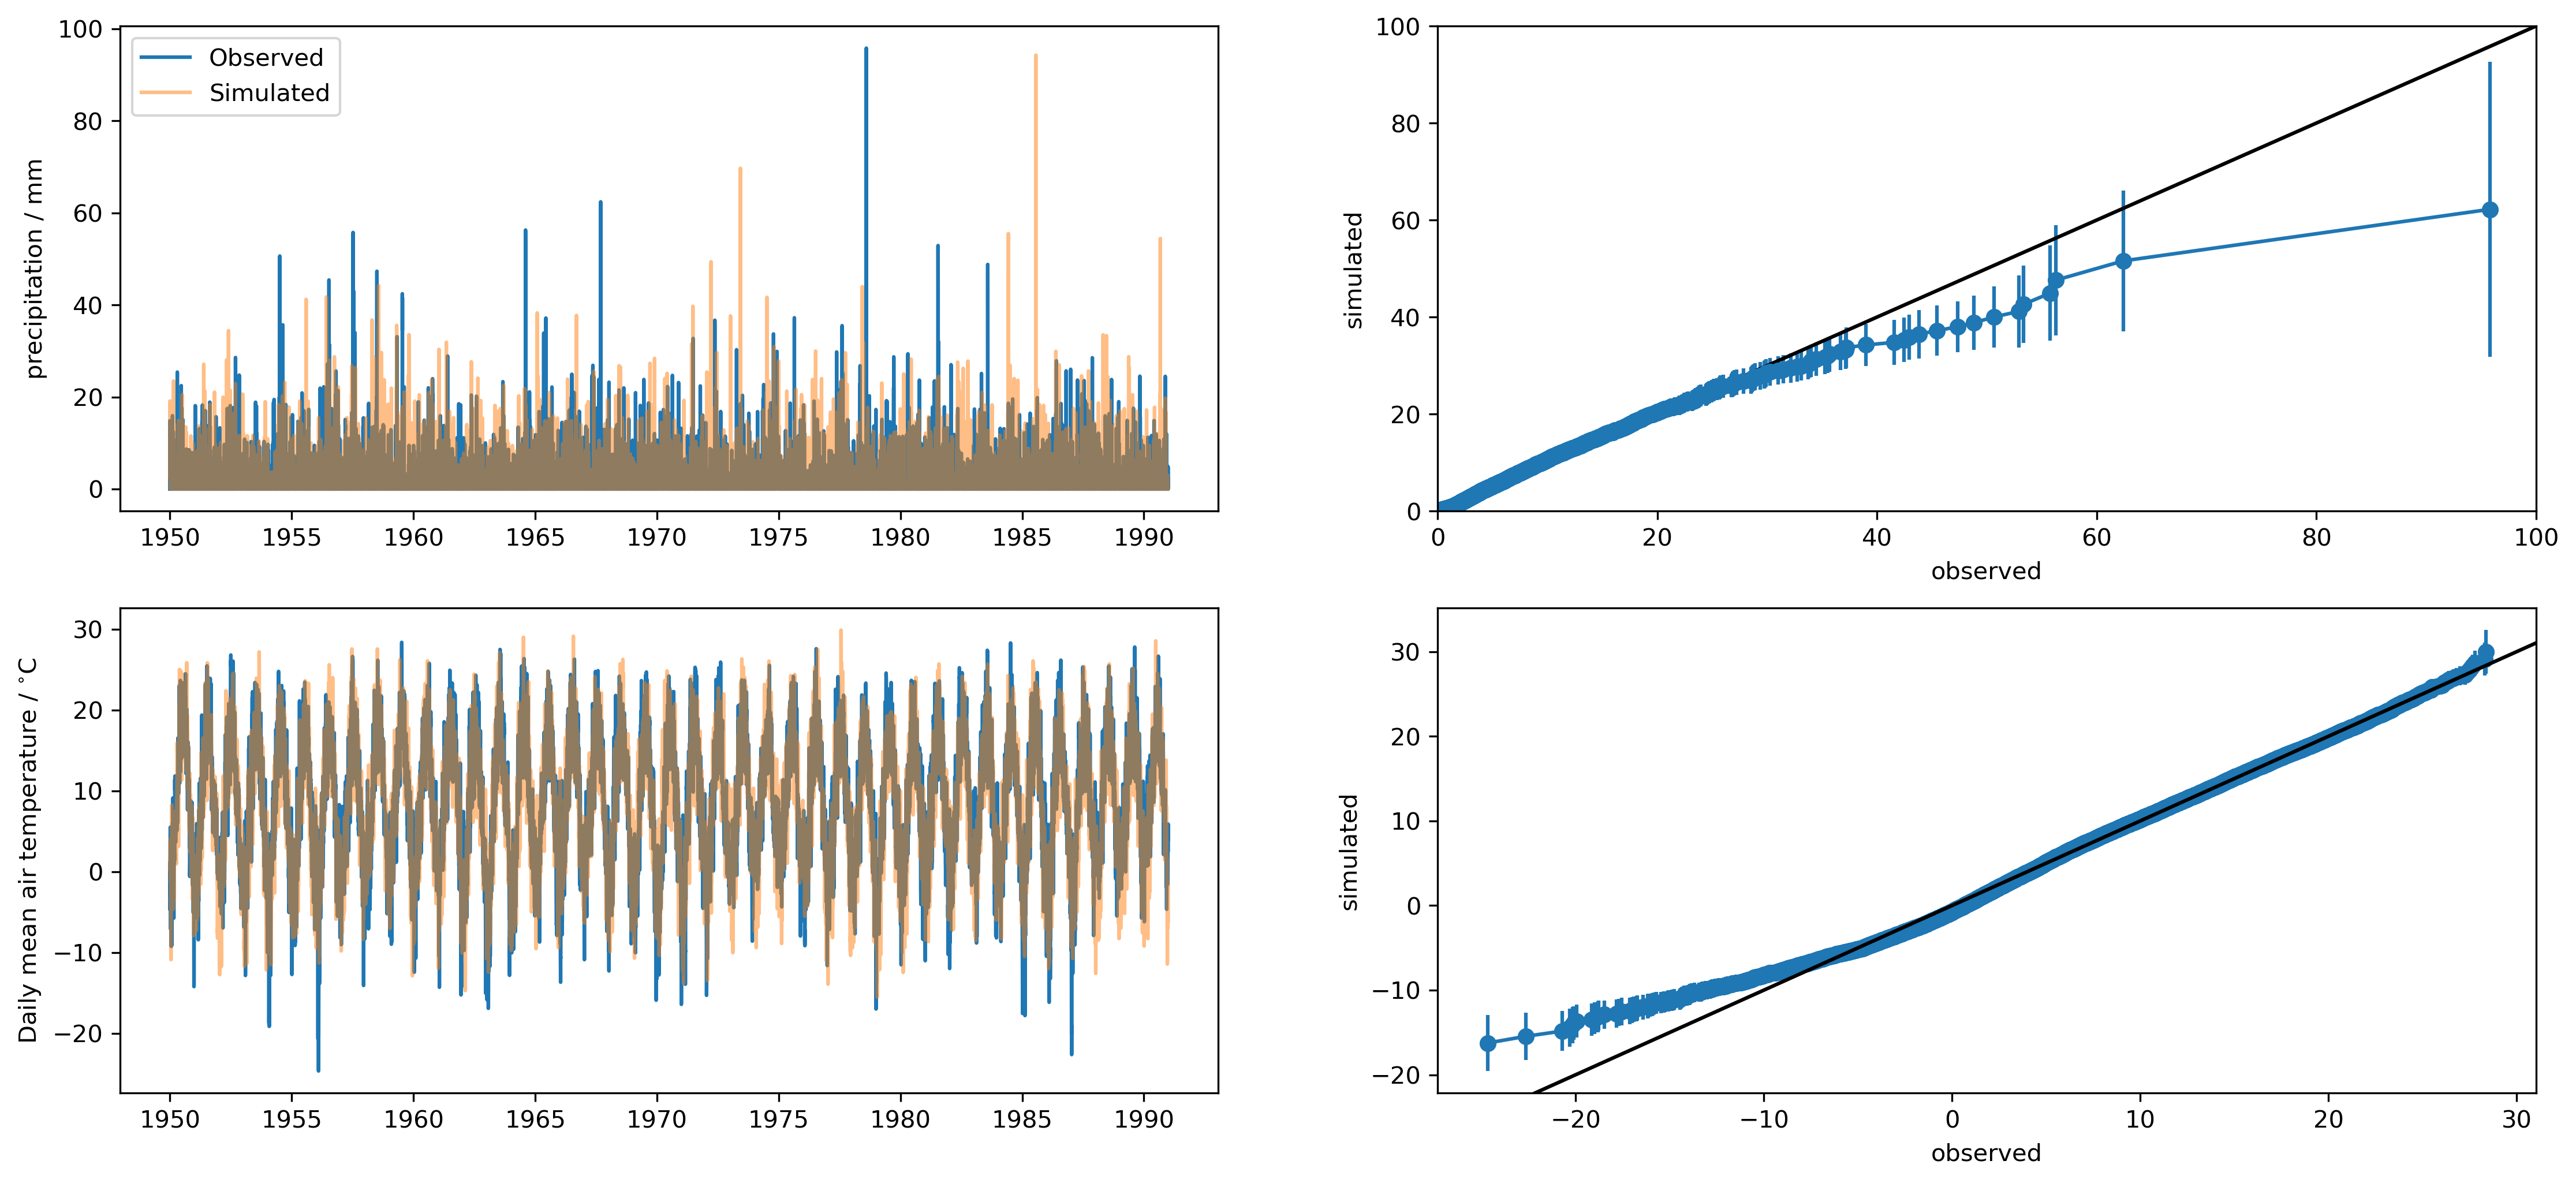

In [28]:
fig, axs = plt.subplots(2,2,figsize=(18,8),dpi=300)
prec_preds = svi_preds['prec'].squeeze().T.sort(axis=0)
prec_obs = obs['prec'].squeeze().sort()
p1 = axs[0,0].plot(basin_data_train.index, obs['prec'].squeeze())
p2 = axs[0,0].plot(basin_data_train.index, svi_preds['prec'].squeeze()[0,:], alpha=0.5)
axs[0,0].set_ylabel("precipitation / mm")
axs[0,0].legend(handles=[p1[0],p2[0]], labels=["Observed","Simulated"])
# plt.scatter(prec_obs, prec_preds.mean(axis=1))
axs[0,1].errorbar(prec_obs, prec_preds.mean(axis=1), yerr=2*prec_preds.std(axis=1), marker="o")
axs[0,1].axline((0,0),slope=1,c='black')
axs[0,1].set_xlabel("observed")
axs[0,1].set_ylabel("simulated")
axs[0,1].set_xlim(0,100)
axs[0,1].set_ylim(0,100)
# air temperature
axs[1,0].plot(basin_data_train.index, obs['Tavg'].squeeze())
axs[1,0].plot(basin_data_train.index, svi_preds['Tavg'].squeeze().T[:,0], alpha=0.5)
axs[1,0].set_ylabel("Daily mean air temperature / $^{\\circ}$C")
Tavg_preds = svi_preds['Tavg'].squeeze().T.sort(axis=0)
Tavg_obs = obs['Tavg'].squeeze().sort()
# plt.scatter(prec_obs, prec_preds.mean(axis=1))
axs[1,1].errorbar(Tavg_obs, Tavg_preds.mean(axis=1), yerr=2*Tavg_preds.std(axis=1), marker="o")
axs[1,1].axline((0,0),slope=1,c='black',zorder=10)
axs[1,1].set_xlabel("observed")
axs[1,1].set_ylabel("simulated")
plt.savefig("../plots/basin_6340800_calibrated_Tair_prec.png")
plt.show()

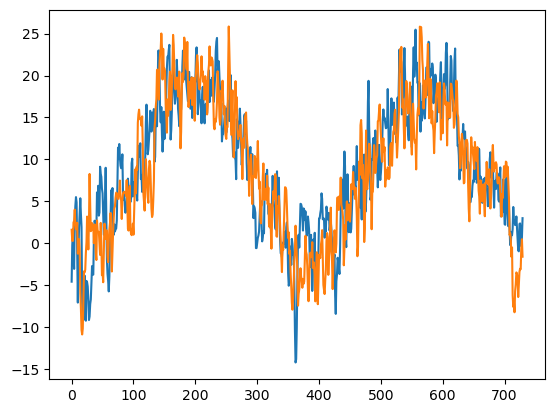

In [29]:
plt.plot(obs['Tavg'].squeeze()[:2*365])
plt.plot(svi_preds['Tavg'].squeeze()[0,:2*365])

(array([1.51081787e-05, 7.31684497e-04, 8.51782591e-03, 2.84636930e-02,
        3.66682610e-02, 3.89746158e-02, 4.37706437e-02, 1.82314436e-02,
        1.36717191e-03, 1.34557239e-05]),
 array([-21.45474815, -15.79716396, -10.13958073,  -4.48199654,
          1.17558706,   6.83317089,  12.49075508,  18.14833832,
         23.80592155,  29.4635067 ,  35.12108994]),
 <BarContainer object of 10 artists>)

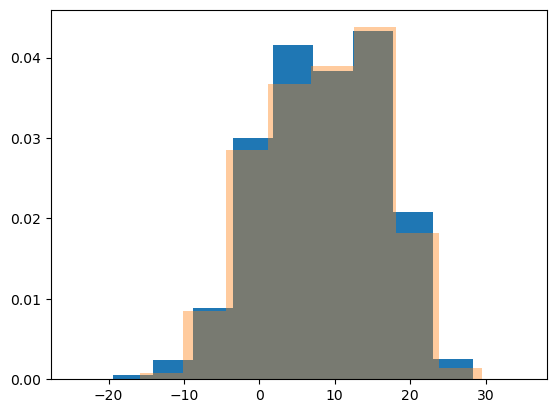

In [30]:
plt.hist(obs['Tavg'].squeeze(), density=True)
plt.hist(svi_preds['Tavg'].squeeze().reshape((-1,)), alpha=0.4, density=True)

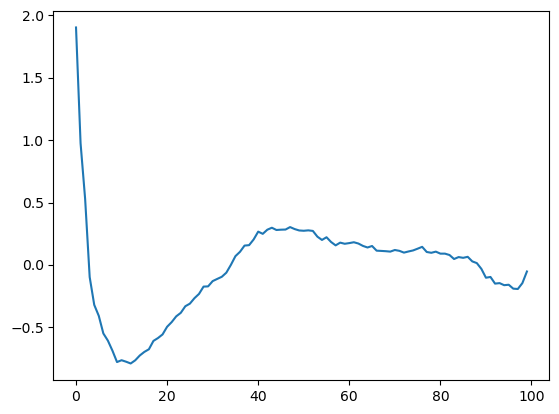

In [31]:
obs_qs = np.quantile(Tavg_obs, np.linspace(0.01,0.99,100))
sim_qs = np.quantile(Tavg_preds.reshape((-1,)), np.linspace(0.01,0.99,100))
# plt.plot(obs_qs, sim_qs)
# plt.axline((0,0),slope=1,c="black")
plt.plot(sim_qs - obs_qs)

<Axes: xlabel='time'>

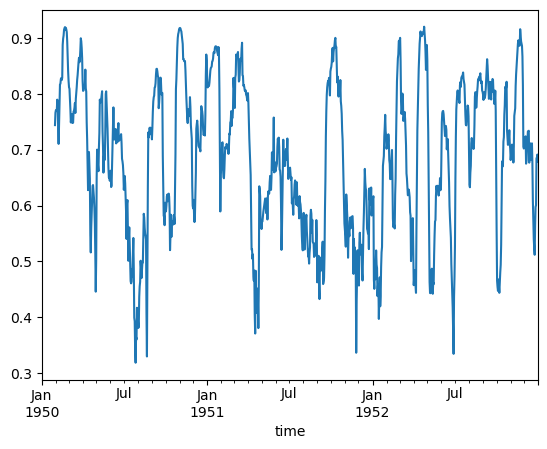

In [32]:
basin_data_ref["1950":"1952"].Tair_mean.rolling(30).apply(lambda x: x.autocorr()).plot()

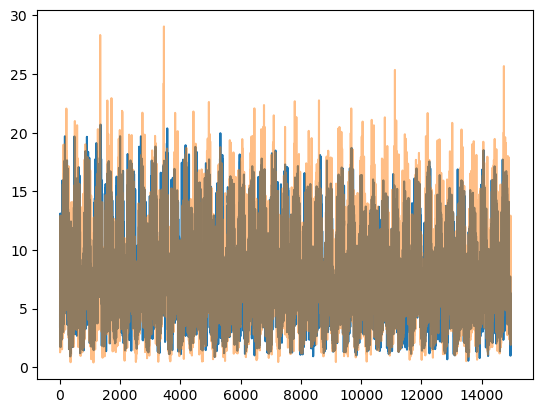

In [33]:
plt.plot(obs['Trange'].squeeze())
plt.plot(svi_preds['Trange'].squeeze().T[:,0], alpha=0.5)

In [34]:
from scipy.stats import gamma
Trange_dist_fit = gamma.fit(obs['Trange'].squeeze())

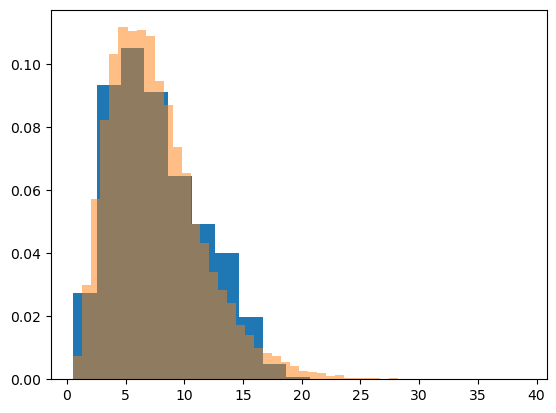

In [35]:
plt.hist(obs['Trange'].squeeze(), density=True)
plt.hist(gamma.rvs(*Trange_dist_fit, size=(len(obs['Trange'].squeeze()),)), alpha=0.5, bins=50, density=True);

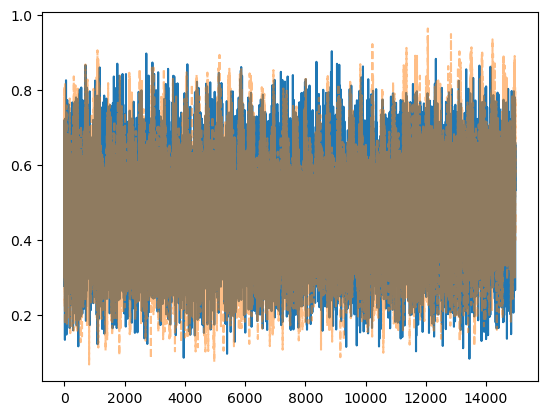

In [36]:
plt.plot(svi_preds['Tskew'].squeeze().T[:,0])
plt.plot(obs['Tskew'].squeeze(), alpha=0.5, linestyle='--')

In [37]:
prng = random.PRNGKey(1234)
map_guide = AutoDelta(wgen.step, init_loc_fn=numpyro.infer.init_to_median)
map_result = wgen.fit("svi", 10_000, map_guide, subsample_time=1000, rng=prng)
with numpyro.handlers.seed(rng_seed=0):
    map_params = map_guide(map_result.params)
map_params

100%|██████████| 10000/10000 [00:39<00:00, 254.61it/s, init loss: 2170171.0000, avg. loss [9501-10000]: 84626.8066]


{'Tavg_lag': Array([0.2460917 , 0.03307007], dtype=float32),
 'Tavg_seasonal': Array([-0.17791437,  0.32026553,  0.1112325 , -0.37223804,  0.26352385,
        -0.12498021,  0.5679875 ,  0.1504611 ,  0.13786098, -0.34758186],      dtype=float32),
 'Tavg_seasonal&lag1': Array([-0.1524601 ,  0.0955489 , -0.37304837,  0.4302713 ,  0.5148561 ,
        -0.4861523 ,  0.2900007 ,  0.4590926 , -0.01749813, -0.65863085],      dtype=float32),
 'Tavg_pred': Array([0.05449953], dtype=float32),
 'log_Tavg_scale_seasonal': Array([-0.42042458, -0.12494405,  0.02744026, -0.15270498,  0.10681768,
         0.03971205,  0.67279935,  0.39173022,  0.31391546,  0.23750922],      dtype=float32),
 'log_Tavg_scale_pred': Array([0.20370153], dtype=float32),
 'precip_occ_seasonal': Array([ 0.43835083,  0.64427936, -0.03315007, -0.08906621,  0.00844942,
         0.2677234 , -0.4259519 ,  0.01215281,  0.5323773 , -0.37767208],      dtype=float32),
 'precip_occ_lag': Array([-0.08591881,  0.01555328, -0.07869928,  0.

In [38]:
# from numpyro.infer import MCMC, NUTS, HMCECS

# # mcmc_kernel = BarkerMH(wx.step_wgen, step_size=0.001, target_accept_prob=0.65, dense_mass=True)
# proxy = HMCECS.taylor_proxy(map_params)
# mcmc_kernel = HMCECS(NUTS(wgen.step, init_strategy=numpyro.infer.init_to_median), num_blocks=10, proxy=proxy)
# # mcmc_kernel = NUTS(wx.step_wgen)
# mcmc = MCMC(mcmc_kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method="parallel")
# prng = random.PRNGKey(1234)
# mcmc.run(prng, subsample_time=100)
# mcmc.print_summary()

In [39]:
# import arviz as az

# with numpyro.handlers.seed(rng_seed=0):
#     idata = az.from_numpyro(mcmc)
# az.plot_trace(idata)

In [40]:
import torch
from jax2torch.jax2torch import jax2torch, j2t, t2j
from sbi.inference import SNPE, SNLE, simulate_for_sbi
from sbi.utils.user_input_checks import process_prior, process_simulator

torch.manual_seed(1234)

In [41]:
wgen = wx.WGEN(basin_data_train, *wgen_args, **wgen_kwargs)
obs = wgen.obs

In [42]:
def precip_summary_stats(pr, cdd_thresh=0.0, axis=0):
    pmean = jnp.mean(pr, axis=axis)
    p95 = jnp.nanquantile(jnp.where(pr > 0, pr, jnp.nan), 0.95, axis=axis)
    rp95 = jnp.nanmean(jnp.where(pr > p95, pr, jnp.nan), axis=axis)
    fwd = jnp.mean(pr > 0, axis=axis)
    cdd = wx.utils.cumulative_dry_days(pr, threshold=cdd_thresh, axis=axis)
    return jnp.stack([pmean, rp95, fwd, cdd])

def tair_summary_stats(Tair_mean, Tair_min, Tair_max):
    Tavg = jnp.mean(Tair_mean, axis=0)
    Trange = jnp.mean(Tair_max - Tair_min, axis=0)
    Tskew = jnp.mean((Tair_mean - Tair_min) / (Tair_max - Tair_min), axis=0)
    ftd = jnp.mean(jnp.where(Tair_mean > 0, 1, 0), axis=0)
    # ffd = jnp.mean(jnp.where(Tair_mean <= 0, 1, 0), axis=0)
    return jnp.stack([Tavg, Trange, Tskew, ftd])

def wgen_summary_stats(ts, precip, Tmin, Tavg, Tmax):
    precip_stats = precip_summary_stats(precip)
    Tair_stats = tair_summary_stats(Tavg, Tmin, Tmax)
    return jnp.concat([precip_stats, Tair_stats], axis=0)
    # return precip_stats

summary_stat_names = ["prec_mean", "rp95", "norm wet days", "mean dry spell length", "Tair_mean", "Tair_range", "Tair_skew", "norm thaw days"]

In [43]:
wgen_sim, wgen_prior = wgen.simulator(observable=wgen_summary_stats, rng_seed=1234)

In [44]:
wgen_prior.sample().shape

(151,)

In [45]:
sim_stats = wgen_sim(wgen_prior.sample(jax.random.PRNGKey(0), (10,)))
sim_stats.shape

(10, 8)

In [46]:
obs['Tmin'] = obs['Tavg'] - obs['Tskew']*obs['Trange']
obs['Tmax'] = obs['Tmin'] + obs['Trange']
obs_stats = wgen_summary_stats(wgen.timestamps[0,:,:], obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats

Array([[ 1.8410039 ],
       [19.911066  ],
       [ 0.46417361],
       [ 3.2737658 ],
       [ 8.464582  ],
       [ 7.665804  ],
       [ 0.48358598],
       [ 0.85248744]], dtype=float32)

We can use the "true" prior of the model by wrapping it in a `torch` distribution as such:

    wx.distributions.NumPyro2TorchDistribution(wgen_prior)

However, the true prior for the GLM-type models is very uninformative and will generate many physically implausible or simply invalid simulations.

The two options here are therefore:

1. Design a better prior
2. Use the SVI calibrated posterior to construct a "better" prior for SBI

The more prinicpled option is (1), but it's also hard and time consuming. So we go with (2) instead :)


In [47]:
wgen_sbi = jax2torch(wgen_sim)
# wgen_sbi_prior = process_prior(wx.distributions.NumPyro2TorchDistribution(wgen_prior))


In [48]:
svi_posterior = guide.get_posterior(svi_result.params)
svi_posterior_torch = torch.distributions.MultivariateNormal(j2t(svi_posterior.mean), j2t(svi_posterior.covariance_matrix))
scale_factor = 2
svi_proposal = torch.distributions.MultivariateNormal(j2t(svi_posterior.mean), j2t(scale_factor**2*jnp.eye(len(svi_posterior.mean))*jnp.diag(svi_posterior.covariance_matrix)))
# svi_proposal = torch.distributions.MultivariateNormal(j2t(svi_posterior.mean), j2t(scale_factor**2*jnp.eye(len(svi_posterior.mean))*svi_posterior.covariance_matrix))

# sample from propsoal prior and run simulations
sbi_prior_samples = svi_proposal.sample((100,))
sbi_prior_obs = wgen_sbi(sbi_prior_samples)

In [49]:
# sample from SVI posterior
svi_posterior_samples = svi_posterior_torch.sample((200,))
svi_posterior_sims = wgen_sbi(svi_posterior_samples)

In [50]:
# sample from variance-inflated proposal
svi_prposoal_samples = svi_proposal.sample((200,))
svi_proposal_sims = wgen_sbi(svi_prposoal_samples)

In [51]:
posterior_sims = pd.DataFrame(svi_posterior_sims.numpy(), columns=summary_stat_names)
proposal_sims = pd.DataFrame(svi_proposal_sims.numpy(), columns=summary_stat_names)

In [52]:
proposal_sims

,prec_mean,rp95,norm wet days,mean dry spell length,Tair_mean,Tair_range,Tair_skew,norm thaw days
0,2.168780,24.294926,0.453689,3.234875,8.170620,8.415282,0.477803,0.798664
1,2.698993,25.887356,0.523139,2.854117,11.929060,9.041175,0.488556,0.824441
2,1.451643,17.978245,0.407679,3.846488,9.699798,8.617366,0.491485,0.764808
3,1.742775,21.325502,0.433790,3.519718,8.861062,7.316300,0.486544,0.825509
4,2.046445,23.495010,0.485743,3.149693,8.165061,7.992734,0.479057,0.834123
...,...,...,...,...,...,...,...,...
195,1.541086,19.498613,0.421770,3.714715,8.964519,8.373535,0.488748,0.814424
196,2.819330,25.362829,0.555927,2.740008,12.131480,8.708127,0.492110,0.913456
197,1.605178,21.214399,0.409416,3.826915,8.823056,8.177993,0.490386,0.849750
198,2.341746,25.059790,0.500367,3.087908,7.873708,7.202477,0.484841,0.783706


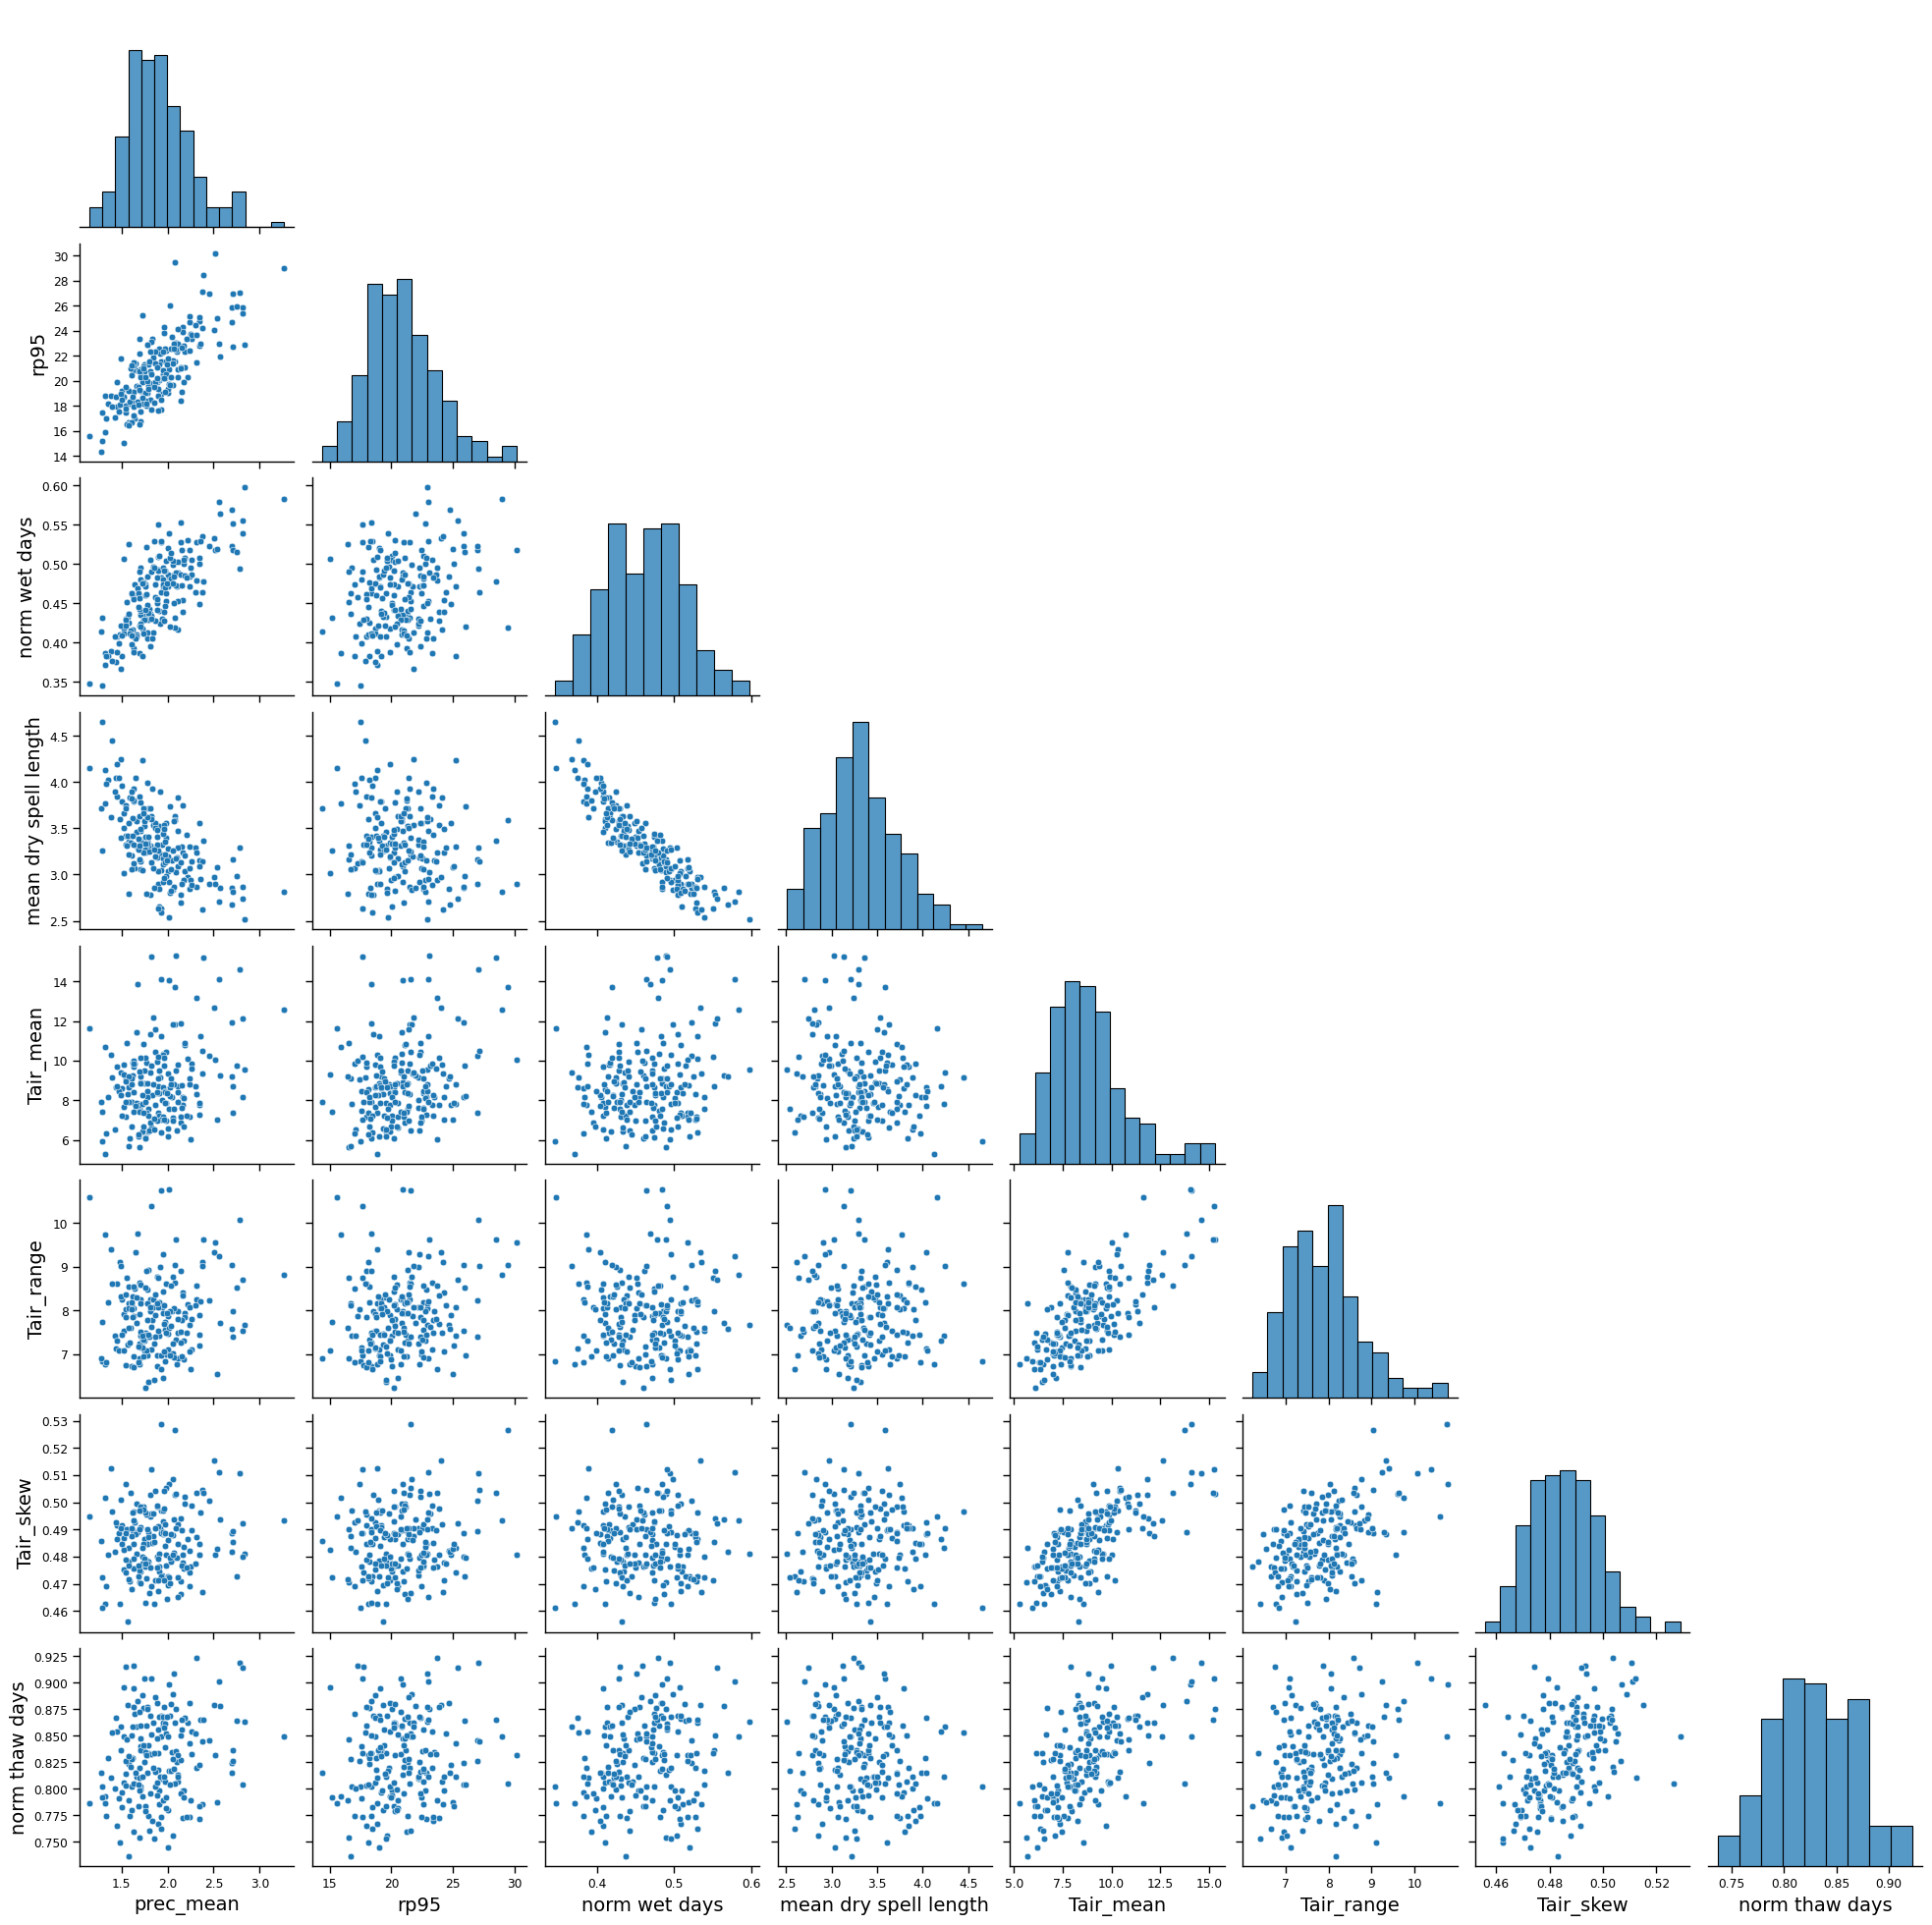

In [53]:
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":14})
sns.pairplot(proposal_sims.dropna(), corner=True)
plt.savefig("../plots/wgen_summary_stats_corner_plot.png")

In [54]:
# compute empirical mean and covariance, dropping rows with nan values
svi_posterior_sims_mean = torch.mean(svi_posterior_sims[torch.isfinite(svi_posterior_sims).all(dim=1),:], dim=0)
svi_proposal_sims_mean = torch.mean(svi_proposal_sims[torch.isfinite(svi_proposal_sims).all(dim=1),:], dim=0)
svi_posterior_sims_cov = torch.cov(svi_posterior_sims[torch.isfinite(svi_posterior_sims).all(dim=1),:].T)
svi_proposal_sims_cov = torch.cov(svi_proposal_sims[torch.isfinite(svi_proposal_sims).all(dim=1),:].T)

<Axes: >

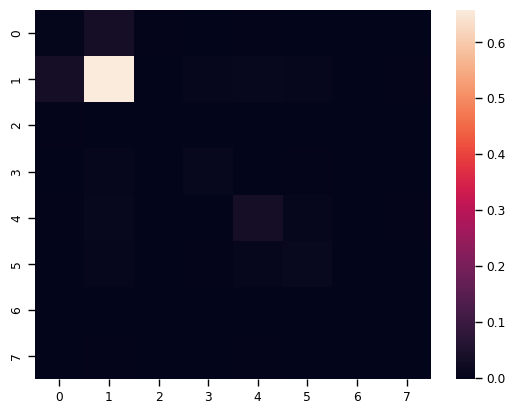

In [55]:
sns.heatmap(svi_posterior_sims_cov.numpy())

<Axes: >

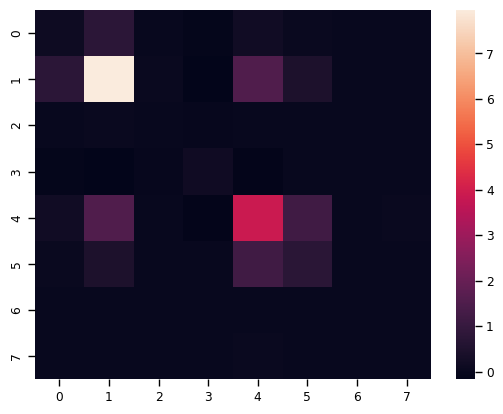

In [56]:
sns.heatmap(svi_proposal_sims_cov.numpy())

In [57]:
proposal_sims_dist = torch.distributions.MultivariateNormal(svi_proposal_sims_mean, svi_proposal_sims_cov)
obs_stats2 = t2j(proposal_sims_dist.sample((1,)).T)
obs_stats2 - obs_stats

Array([[-2.2059929e-01],
       [-2.5861397e+00],
       [ 2.3630589e-02],
       [-2.1010780e-01],
       [-1.9354072e+00],
       [-1.9939728e+00],
       [-8.5899234e-03],
       [ 4.4995546e-04]], dtype=float32)

In [60]:
num_simulations = 2000
num_rounds = 1 # for some reason, single round inference seems to work much better than multi-round. might need to report this to the sbi developers?
proposal = svi_proposal
sbi_alg = SNPE(proposal)
# sbi_alg = SNLE(proposal)

In [61]:
for i in range(num_rounds):
    print(f"Starting SBI round {i+1}/{num_rounds}")
    theta, x = simulate_for_sbi(wgen_sbi, proposal=proposal, num_simulations=num_simulations, simulation_batch_size=200)
    sbi_alg.append_simulations(theta, x, proposal, exclude_invalid_x=True)
    density_estimator = sbi_alg.train()
    sbi_posterior = sbi_alg.build_posterior(density_estimator).set_default_x(j2t(obs_stats.squeeze()))
    proposal = sbi_posterior
    print("")

Starting SBI round 1/1


  0%|          | 0/10 [00:00<?, ?it/s]

 Neural network successfully converged after 163 epochs.


In [62]:
# sample from SBI posterior
sbi_samples = sbi_posterior.sample((200,))
sbi_posterior_sims = wgen_sbi(sbi_samples)

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

In [63]:
# sample from recalibrated SBI posterior
obs_target = obs_stats2
sbi_samples2 = sbi_posterior.sample((200,), x=j2t(obs_target[:,0]))
sbi_posterior_sims2 = wgen_sbi(sbi_samples2)

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

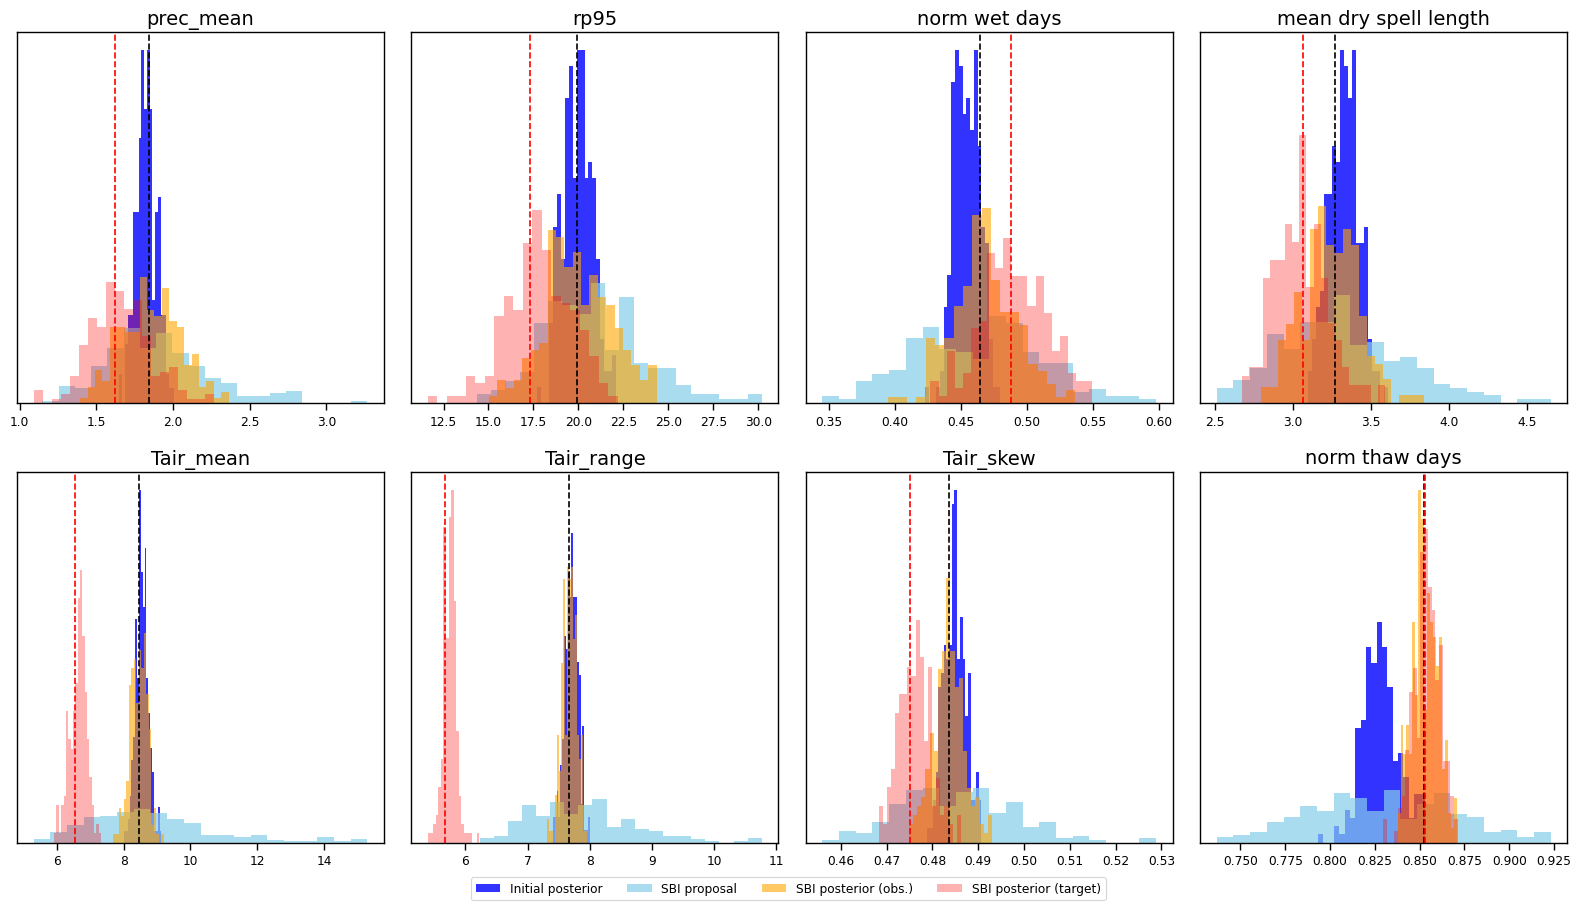

In [64]:
ncols = 4
nrows = 2
fig, axs = plt.subplots(nrows,ncols,figsize=(16,9))
for i in range(obs_stats.shape[0]):
    c = i % ncols
    r = i // ncols
    _,_,h1 = axs[r,c].hist(svi_posterior_sims.numpy()[:,i], bins=20, density=True, color='blue', alpha=0.8, label="SVI posterior")
    _,_,h2 = axs[r,c].hist(svi_proposal_sims.numpy()[:,i], bins=20, density=True, color='skyblue', alpha=0.7, label="SBI prior")
    _,_,h3 = axs[r,c].hist(sbi_posterior_sims.numpy()[:,i], bins=20, density=True, color='orange', alpha=0.6, label="SBI posterior")
    _,_,h4 = axs[r,c].hist(sbi_posterior_sims2.numpy()[:,i], bins=20, density=True, color='red', alpha=0.3, label="SBI posterior (recalibrated)")
    axs[r,c].axvline([obs_stats[i,:]], c='black', linestyle="--")
    axs[r,c].axvline([obs_target[i,:]], c='red', linestyle="--")
    axs[r,c].set_yticks([])
    axs[r,c].set_title(summary_stat_names[i])
for i in range(obs_stats.shape[0], ncols*nrows):
    c = i % ncols
    r = i // ncols
    fig.delaxes(axs[r,c])
labels = ["Initial posterior", "SBI proposal", "SBI posterior (obs.)", "SBI posterior (target)"]
fig.legend(handles=[h1,h2,h3,h4], labels=labels, ncol=4, loc="lower center", bbox_to_anchor=(0.5,-0.02))
plt.tight_layout()
plt.savefig("../plots/basin_6340800_sbi_posterior_all_recalibrated.png")
plt.show()

In [65]:
sbi_posterior_sims2_shift = t2j(sbi_posterior_sims2.mean(axis=0))
sbi_posterior_sims2_scale = t2j(sbi_posterior_sims2.std(axis=0))
sbi_posterior_sims2_standardized = (t2j(sbi_posterior_sims2) - sbi_posterior_sims2_shift) / sbi_posterior_sims2_scale
posterior_obs_resid = sbi_posterior_sims2_standardized - (obs_target.T - sbi_posterior_sims2_shift) / sbi_posterior_sims2_scale
posterior_obs_resid.shape

(200, 8)

(array([ 3.,  3., 19., 36., 52., 44., 21., 15.,  4.,  3.]),
 array([-2.66568184, -2.07471371, -1.48374557, -0.8927775 , -0.3018094 ,
         0.2891587 ,  0.88012683,  1.47109497,  2.06206298,  2.65303111,
         3.24399924]),
 <BarContainer object of 10 artists>)

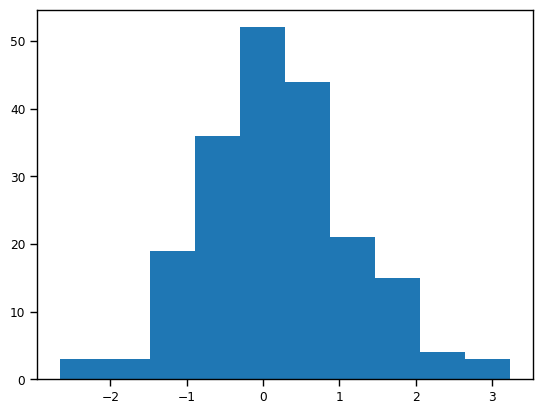

In [66]:
plt.hist(posterior_obs_resid[:,0])

In [67]:
summary_stats_df = basin_data_train[["prec","Tair_min","Tair_mean","Tair_max"]].groupby(basin_data_train.index.year).apply(lambda df: pd.DataFrame(wgen_summary_stats(df.index.values, df.prec.values, df.Tair_min.values, df.Tair_mean.values, df.Tair_max.values).reshape((1,-1)), columns=summary_stat_names)).reset_index().drop("level_1", axis=1)
summary_stats_df.describe()

,time,prec_mean,rp95,norm wet days,mean dry spell length,Tair_mean,Tair_range,Tair_skew,norm thaw days
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,1970.000000,1.841034,19.146120,0.464165,3.295445,8.464806,7.665947,0.483585,0.852496
std,11.979149,0.353711,4.528127,0.048617,0.514934,0.769984,0.580928,0.026299,0.049317
min,1950.000000,1.057300,13.098458,0.372603,2.553846,6.581241,6.549250,0.447778,0.753425
25%,1960.000000,1.523839,15.737223,0.427397,2.885246,7.802209,7.438528,0.464979,0.816940
50%,1970.000000,1.854292,18.018492,0.476712,3.216667,8.450788,7.685133,0.475402,0.852055
75%,1980.000000,2.098828,21.663124,0.498630,3.649123,9.033152,8.031537,0.493390,0.887671
max,1990.000000,2.655576,28.655827,0.546448,4.571429,10.052711,9.160261,0.537237,0.972603


In [68]:
obs_stats3 = obs_stats.at[1].add(5.0).at[2].add(-0.1).at[3].add(0.5)
obs_stats3 - obs_stats

Array([[ 0.        ],
       [ 5.        ],
       [-0.09999999],
       [ 0.5       ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]], dtype=float32)

In [90]:
# sample from recalibrated SBI posterior
obs_target = obs_stats3
sbi_samples3 = sbi_posterior.sample((200,), x=j2t(obs_target[:,0]))
sbi_samples3_mean = torch.quantile(sbi_samples3, q=0.5, axis=0, keepdims=True)*torch.ones((200,1))
sbi_posterior_sims3 = wgen_sbi(sbi_samples3_mean)

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

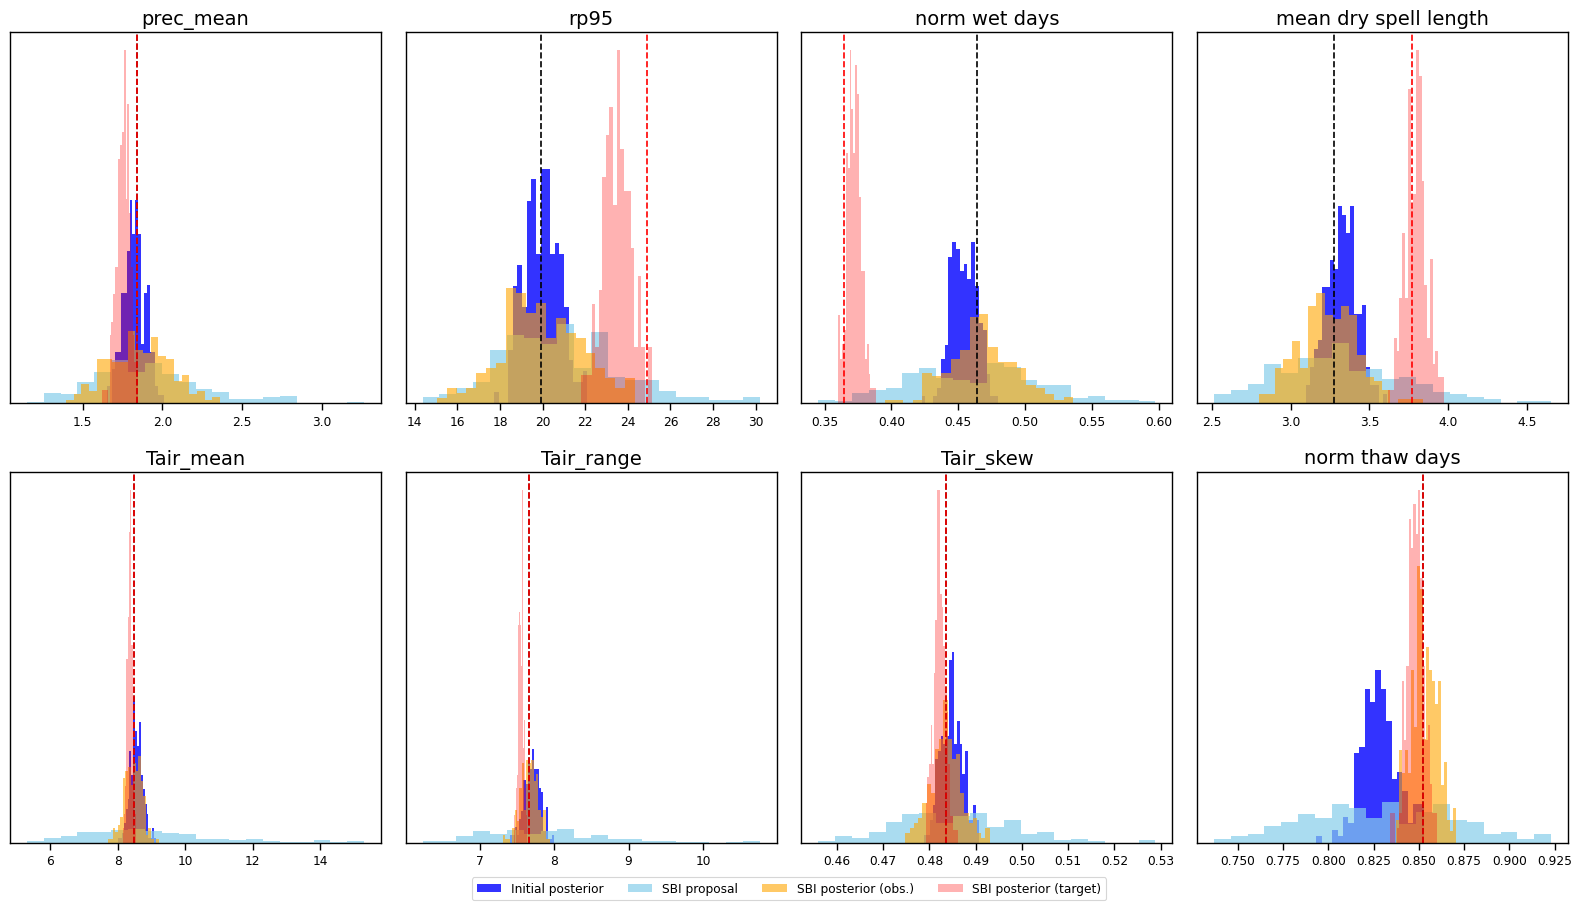

In [91]:
ncols = 4
nrows = 2
fig, axs = plt.subplots(nrows,ncols,figsize=(16,9))
for i in range(obs_stats.shape[0]):
    c = i % ncols
    r = i // ncols
    _,_,h1 = axs[r,c].hist(svi_posterior_sims.numpy()[:,i], bins=20, density=True, color='blue', alpha=0.8)
    _,_,h2 = axs[r,c].hist(svi_proposal_sims.numpy()[:,i], bins=20, density=True, color='skyblue', alpha=0.7)
    _,_,h3 = axs[r,c].hist(sbi_posterior_sims.numpy()[:,i], bins=20, density=True, color='orange', alpha=0.6)
    _,_,h4 = axs[r,c].hist(sbi_posterior_sims3.numpy()[:,i], bins=20, density=True, color='red', alpha=0.3)
    axs[r,c].axvline([obs_stats[i,:]], c='black', linestyle="--")
    axs[r,c].axvline([obs_target[i,:]], c='red', linestyle="--")
    axs[r,c].set_yticks([])
    axs[r,c].set_title(summary_stat_names[i])
for i in range(obs_stats.shape[0], ncols*nrows):
    c = i % ncols
    r = i // ncols
    fig.delaxes(axs[r,c])
labels = ["Initial posterior", "SBI proposal", "SBI posterior (obs.)", "SBI posterior (target)"]
fig.legend(handles=[h1,h2,h3,h4], labels=labels, ncol=4, loc="lower center", bbox_to_anchor=(0.5,-0.02))
plt.tight_layout()
plt.savefig("../plots/basin_6340800_sbi_posterior_rp95_wd_cdd_recalibrated.png")
plt.show()

In [76]:
sbi_posterior_samples_mean = sbi_samples.mean(axis=0, keepdims=True)
sbi_posterior_sims_mean = wgen_sbi(sbi_posterior_samples_mean)
sbi_posterior_sims_mean

tensor([[ 1.8619, 19.4262,  0.4733,  3.1649,  8.2823,  7.6402,  0.4817,  0.8483]])

In [71]:
sbi_params1 = wgen_prior.constrain(t2j(sbi_samples), as_dict=True)
sbi_params2 = wgen_prior.constrain(t2j(sbi_samples2), as_dict=True)
sbi_params3 = wgen_prior.constrain(t2j(sbi_samples3), as_dict=True)

In [69]:
sbi_predictive1 = Predictive(wgen.simulate, posterior_samples=sbi_params1, parallel=True)
sbi_preds1 = sbi_predictive1(prng)

In [70]:
sbi_predictive2 = Predictive(wgen.simulate, posterior_samples=sbi_params2, parallel=True)
sbi_preds2 = sbi_predictive2(prng)

In [71]:
sbi_predictive3 = Predictive(wgen.simulate, posterior_samples=sbi_params3, parallel=True)
sbi_preds3 = sbi_predictive3(prng)

In [72]:
sbi_preds1["Tavg"].shape

(200, 14975, 1)

In [73]:
wgen.obs['Tavg'].shape

(1, 14975)

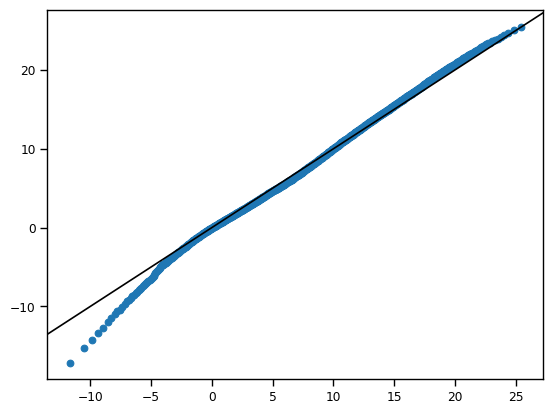

In [74]:
Tavg_preds1 = sbi_preds1["Tavg"].flatten().sort()
Tavg_obs1 = wgen.obs["Tavg"].squeeze().sort()
plt.scatter(np.quantile(Tavg_preds1, np.arange(0.001,0.999,0.001)), np.quantile(Tavg_obs1, np.arange(0.001,0.999,0.001)))
plt.axline((0,0),slope=1,color="black")

In [75]:
import xarray as xr

def to_xarray(data, preds):
    timestamps = data.index
    Tavg_sims = xr.DataArray(preds["Tavg"].squeeze(), dims=("sample","time"), coords={"time": timestamps.values}, name="Tavg_sim")
    Tmin_sims = xr.DataArray(preds["Tmin"].squeeze(), dims=("sample","time"), coords={"time": timestamps.values}, name="Tmin_sim")
    Tmax_sims = xr.DataArray(preds["Tmax"].squeeze(), dims=("sample","time"), coords={"time": timestamps.values}, name="Tmax_sim")
    prec_sims = xr.DataArray(preds["prec"].squeeze(), dims=("sample","time"), coords={"time": timestamps.values}, name="prec_sim")
    obs = data.to_xarray().astype(np.float32)
    return xr.merge([Tavg_sims, Tmin_sims, Tmax_sims, prec_sims, obs])

In [76]:
sbi_sims1_arr = to_xarray(basin_data_train[["Tair_mean","Tair_min","Tair_max","prec"]].iloc[wgen.first_valid_idx:,:], sbi_preds1)
sbi_sims2_arr = to_xarray(basin_data_train[["Tair_mean","Tair_min","Tair_max","prec"]].iloc[wgen.first_valid_idx:,:], sbi_preds2)
sbi_sims3_arr = to_xarray(basin_data_train[["Tair_mean","Tair_min","Tair_max","prec"]].iloc[wgen.first_valid_idx:,:], sbi_preds3)

In [77]:
sbi_sims1_arr.to_netcdf("../data/products/wgen_glm_v3_basin=6340800_sbi_obs_stats.nc")
sbi_sims2_arr.to_netcdf("../data/products/wgen_glm_v3_basin=6340800_sbi_rand_stats.nc")
sbi_sims3_arr.to_netcdf("../data/products/wgen_glm_v3_basin=6340800_sbi_tuned_stats.nc")

In [78]:
sbi_sims1_arr

<xarray.Dataset> Size: 48MB
Dimensions:    (time: 14975, sample: 200)
Coordinates:
  * time       (time) datetime64[ns] 120kB 1950-01-01 1950-01-02 ... 1990-12-31
Dimensions without coordinates: sample
Data variables:
    Tavg_sim   (sample, time) float32 12MB 2.433 3.484 3.29 ... 2.171 1.304
    Tmin_sim   (sample, time) float32 12MB -3.488 2.02 -0.4006 ... 1.022 -0.4841
    Tmax_sim   (sample, time) float32 12MB 8.996 5.806 5.491 ... 4.115 5.125
    prec_sim   (sample, time) float32 12MB 0.0 0.0 5.212 3.885 ... 0.0 0.0 0.0
    Tair_mean  (time) float32 60kB -4.592 -0.241 1.185 ... 4.872 5.884 4.019
    Tair_min   (time) float32 60kB -5.684 -5.416 -0.2187 ... 0.4121 3.41 1.914
    Tair_max   (time) float32 60kB -2.228 0.9776 2.022 ... 6.171 9.602 6.355
    prec       (time) float32 60kB 0.0 14.84 3.41 2.306 ... 0.0 4.842 0.0 2.197